In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Access files in your Drive
file_path = '/content/drive/MyDrive/Agricultural-crops/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the input shape and other parameters
input_shape = (224, 224, 3)
batch_size = 32

# Create an ImageDataGenerator for extracting class labels
data_gen = ImageDataGenerator(rescale=1.0/255.0)

# Flow the data from the directory to extract class labels
data_generator = data_gen.flow_from_directory(
    file_path,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False to get ordered class labels
)

# Get the class labels
class_labels = data_generator.class_indices

# Print the class labels
print("Class Labels:")
print(class_labels)

# Get the list of unique class names
crop_classes = list(class_labels.keys())

# Print the crop classes
print("Crop Classes:")
print(crop_classes)


Found 207 images belonging to 7 classes.
Class Labels:
{'Cucumber': 0, 'Tobacco-plant': 1, 'jute': 2, 'maize': 3, 'mustard-oil': 4, 'rice': 5, 'wheat': 6}
Crop Classes:
['Cucumber', 'Tobacco-plant', 'jute', 'maize', 'mustard-oil', 'rice', 'wheat']


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Access files in your Drive
file_path = '/content/drive/MyDrive/Agricultural-crops/'

# Define input image size
input_size = (224, 224)
input_shape = input_size + (3,)

# Define the number of crop classes
num_classes = 7

# Load the VGG16 model with weights pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom layers on top of the base model for crop classification
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model for crop classification
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the weights of the base model except for the last few layer for fine-tuning
for layer in base_model.layers[:-2]:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Compile the model with a small learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Define batch size and number of epochs
batch_size = 32
epochs = 25
# Load and preprocess your crop classification dataset using ImageDataGenerator
train_data_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_data_gen.flow_from_directory(
    file_path,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_data_gen.flow_from_directory(
    file_path,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Train the model on your crop classification datasets
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

# Save the model for later use
model.save('/content/drive/MyDrive/Agricultural-crops/crop_classification_model_fine_tuned.h5')


Mounted at /content/drive
58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                    

In [ ]:
# Save the model for later use
model.save('/content/drive/MyDrive/Agricultural-crops/crop_classification_model_fine_tuned.h5')

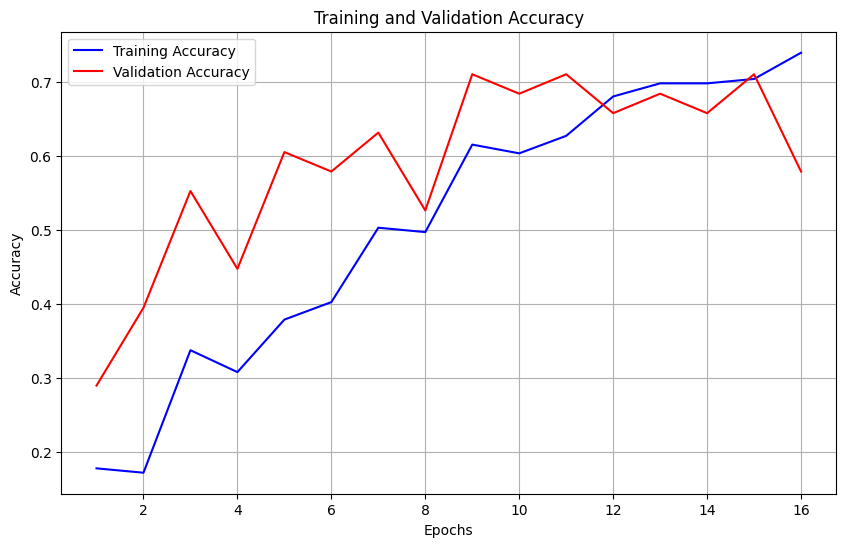

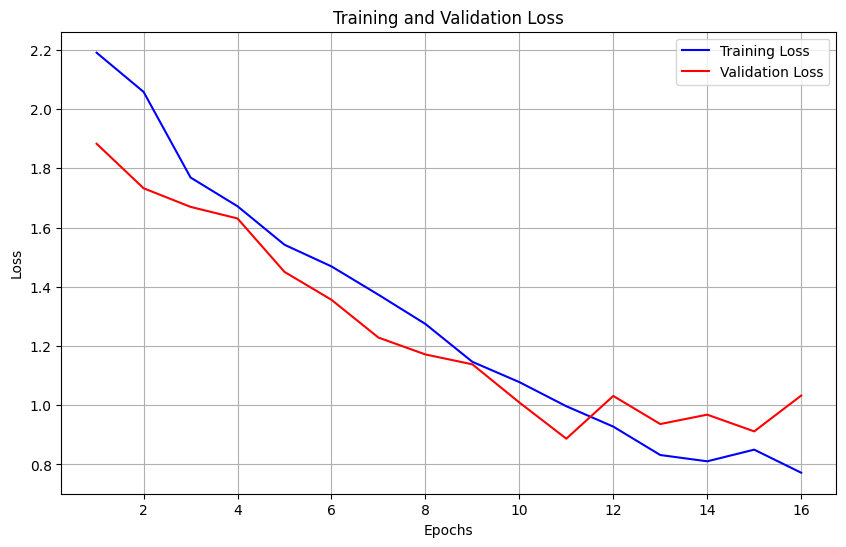

In [ ]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


2/2 [==============================] - 30s 8s/step


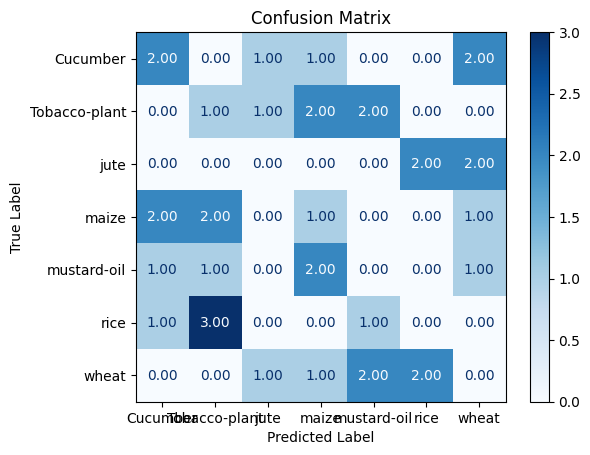

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have the true labels for the validation data
true_labels = validation_generator.classes

# Get the predicted labels from the model
predicted_labels = np.argmax(model.predict(validation_generator), axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class labels (if you have a specific order for your classes)
class_labels = validation_generator.class_indices.keys()

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
# Load and preprocess your test set
test_data_gen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_data_gen.flow_from_directory(
    file_path,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for the test set to keep the order of samples
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Found 207 images belonging to 7 classes.
7/7 [==============================] - 141s 19s/step - loss: 0.7966 - accuracy: 0.7536
Test Loss: 0.796570360660553
Test Accuracy: 0.7536231875419617


In [ ]:
model

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image

# Load the fine-tuned model from the saved file
model_path = '/content/drive/MyDrive/Agricultural-crops/crop_classification_model_fine_tuned.h5'
model = load_model(model_path)

# Function to preprocess the query image for prediction
def preprocess_query_image(image_path, input_size):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(input_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to predict the crop class from the query image
def predict_crop_class(image_path, model, input_size, crop_classes):
    query_image = preprocess_query_image(image_path, input_size)
    predictions = model.predict(query_image)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_crop_class = crop_classes[predicted_class_index]

    # Define the recommended and alternative soil types for each crop
    recommended_soil = {
        'Cucumber': 'Sandy loam, loam',
        'Tobacco-plant': 'Silt loam, clay loam',
        'jute': 'Sandy loam, clay loam',
        'maize': 'Loam, clay loam',
        'mustard-oil': 'Silt loam, loam',
        'rice': 'Clay loam, clay',
        'wheat': 'Silt loam, clay loam'
    }

    alternative_soil = {
        'Cucumber': 'Clay, silt, loam',
        'Tobacco-plant': 'Clay, loam',
        'jute': 'Sandy soil, loam',
        'maize': 'Sandy loam, loam',
        'mustard-oil': 'Clay loam, loam',
        'rice': 'Loam, sandy loam',
        'wheat': 'Sandy loam, clay loam'
    }

    # Get the recommended and alternative soil types for the predicted crop class
    recommended_soil_type = recommended_soil[predicted_crop_class]
    alternative_soil_type = alternative_soil[predicted_crop_class]

    return predicted_crop_class, recommended_soil_type, alternative_soil_type

# Define the crop classes
crop_classes = ['Cucumber', 'Tobacco-plant', 'jute', 'maize', 'mustard-oil', 'rice', 'wheat']

# Example: Test the model by providing a query image path
query_image_path = '/content/drive/MyDrive/test/query_image.jpg'
predicted_crop, recommended_soil, alternative_soil = predict_crop_class(query_image_path, model, input_size, crop_classes)

# Display the predicted crop class and soil information
print("Predicted Crop Class:", predicted_crop)
print("Recommended Soil:", recommended_soil)
print("Alternative Soil:", alternative_soil)


1/1 [==============================] - 3s 3s/step
Predicted Crop Class: jute
Recommended Soil: Sandy loam, clay loam
Alternative Soil: Sandy soil, loam


In [ ]:
# Save the model for later use
model.save('/content/drive/MyDrive/Agricultural-crops/crop_classification_model_fine_tuned.h5')